# 

# TODO

1. Generating the lattices and bases -> farm out to the HPC
2. Diagonalise and measure ringflip exp val DONE!
3. Resolve the confusion about the perturbative ring DONE!

In [1]:
import scipy.sparse.linalg as sLA
from tqdm import tqdm
import visual
from lattice import Lattice
import matplotlib.pyplot as plt


In [2]:
from ringflip_hamiltonian import RingflipHamiltonian, build_matrix, ring_exp_values



In [3]:




# visualisation methods
def show_lattice(h: RingflipHamiltonian):
        fig =plt.figure()
        ax=fig.add_axes([0,0,1,1],projection='3d')
        # visual.plot_cell(ax, h.lattice)
        visual.plot_atoms(ax, h.lattice)
        return fig, ax


def show_state(l: Lattice, state: int):
    fig =plt.figure()
    ax=fig.add_axes([0,0,1,1],projection='3d')
    # visual.plot_cell(ax, h.lattice)
    for (i, a) in enumerate(l.atoms):
        ax.scatter(*[int(x) for x in a.xyz], color='k' if state&(1<<i) else 'red')
        
    
    


In [37]:
cellspec = [[3,0,0],[0,-3,0],[0,0,-2]]
# cellspec = [[1,-1,-1],[1,-1,1],[1,1,-1]]
import pyrochlore

lat = pyrochlore.import_json("../lattice_files/pyro_1_3_6x-12,-4,-8b0,-4,-4b4,0,4b1.json")
full_lat = RingflipHamiltonian(lat)
full_lat.calc_basis(recalc=False)
# name = "%d%d%d_%d%d%d_%d%d%d" % tuple(x for x in np.ravel(cellspec))
# pyrochlore.export_json(full_lat.lattice, "../lattice_files/pyro_"+name+".json")

Basis stats: 310 charge sectors, total dim 12846186


In [13]:
sectors = list(full_lat.sectors)


In [16]:
# full_lat.set_ring_exchange([1,1,1,1])
import numpy as np

def calc_spectrum(g, lat:RingflipHamiltonian):
    results = {}
    for s in full_lat.sectors:
        H = build_matrix(full_lat, g=[-1,-1,-1,-1], sector=s)
        
        if H.shape[0] < 100:
            e, v = np.linalg.eigh(H.todense())
            results[s] = (e,v)
        else:
            e, v = sLA.eigs(H,k=30,which='SR')
            results[s] = (e,v)
    return results
        

res = calc_spectrum([1,1,1,1], full_lat)


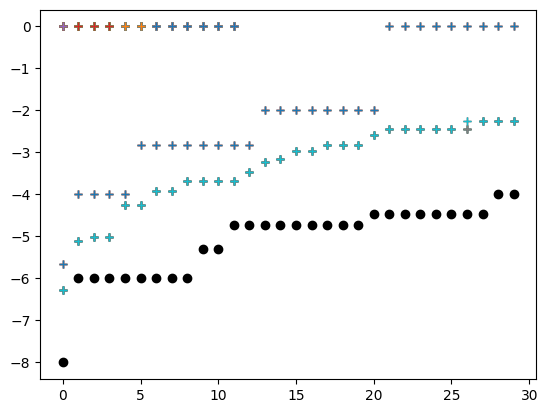

In [25]:
# plt.plot(np.real(np.sort(e1)),'kx',label='lanczos')
for s in res:
    e, v = res[s]
    plt.plot(np.sort(e)[:30],'+', label=str(s))

plt.plot(np.sort(res[(4,4,4,4)][0]),'ko')

# plt.legend()
exps = ring_exp_values(full_lat, (4,4,4,4), res[(4,4,4,4)][1][:,:6])

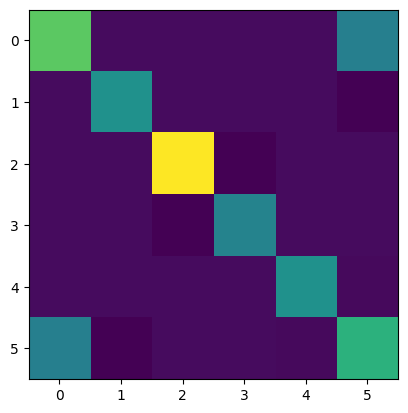

In [29]:
plt.imshow(np.real(exps[0]))

In [ ]:
fig =plt.figure()
ax=fig.add_axes([0,0,1,1],projection='3d')

rf = full_lat.ringflips[0]

hexa = [full_lat.lattice.atoms[j].xyz for j in rf.members]

X = [float(hexa[-1][0])]
Y = [float(hexa[-1][1])]
Z = [float(hexa[-1][2])]

for xyz in hexa:
    X.append(float(xyz[0]))
    Y.append(float(xyz[1]))
    Z.append(float(xyz[2]))
    
ax.plot(X, Y ,Z,color='k',lw=3)
# ax.plot([0,-1],[0,-1],[0,-1],lw=3)
visual.plot_cell(ax, full_lat.lattice)
rf.sl

In [ ]:
full_lat.lattice.atoms[0].sl_name

In [ ]:

def visualise_state(ax, l:RingflipHamiltonian, state:int):
    # input->state: understood as a bitstring
    for i,a in enumerate(l.lattice.atoms):
        
        
        color='k'if (state&(1<<i)) == 0 else 'white'

        ax.plot(*a.xyz, 'o', 
                color = color,
               markeredgecolor='k' 
               )
        

In [ ]:

fig =plt.figure()
ax=fig.add_axes([0,0,1,1],projection='3d')

visualise_state(ax, full_lat, full_lat.basis[55])


In [ ]:
res = partition_polarisation_sectors(full_lat.basis, full_lat.lattice)

In [ ]:
res

In [ ]:
len(res[(4,4,4,4)])